# Import Libraries 

In [65]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# Import matplotlib library and set dark mode
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [66]:
# Change notebook to dark mode
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('monokai')

# Data Preparation

In [67]:
# Get data
df_train = pd.read_csv(r"C:\Users\richard.dudbridge\Documents\Python Scripts\Titanic Data\train.csv")
df_test = pd.read_csv(r"C:\Users\richard.dudbridge\Documents\Python Scripts\Titanic Data\test.csv")

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


First lets look at whether there is any miss values in the data

In [68]:
# Count nan values in data
df_train.isnull().sum(axis = 0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [69]:
df_test.isnull().sum(axis = 0)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

You can see that age, fare cabin and embarked all have missing values. Let's drop cabin as there are too many values missing

In [70]:
# Cabin dropped as most entries are empty
drop_column = ['Cabin']
df_train.drop(drop_column, axis = 1, inplace = True)
df_test.drop(drop_column, axis = 1, inplace = True)

# Passenger Id dropped
df_train = df_train.drop(['PassengerId'], axis =1)

Age, fare and embarked all have nan values. As age is numeric, the average will be used to fill in the blanks. As the embarked is discrete data the missing values will be replaced with the mode value.

In [71]:
# nan values of age and fare replaced with the mean
df_train['Age'].fillna(df_train['Age'].mean(), inplace = True)
df_test['Age'].fillna(df_train['Age'].mean(), inplace = True)
df_train['Fare'].fillna(df_train['Fare'].mean(), inplace = True)
df_test['Fare'].fillna(df_train['Fare'].mean(), inplace = True)

In [72]:
# Replace nan embarked columns with the mode
for column in ['Embarked']:
    df_train[column].fillna(df_train[column].mode()[0], inplace = True)
    
for column in ['Embarked']:
    df_test[column].fillna(df_train[column].mode()[0], inplace = True)

Check type of features in df

In [73]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


You can see that that there are 2 float features and 4 categorical features. Firstly, the floats will be converted to integers

In [74]:
# Convert both test and train dfs to lists
data = [df_train, df_test]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].astype(int)
    dataset['Age'] = dataset['Age'].astype(int)

Next, the categorical columns need to be converted to numerical. Firstly, the title from the names will be extracted and assigned a number

In [75]:
# Convert both test and train dfs to lists
data = [df_train, df_test]
# Create dictionary with title numberical replacements 
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
    
    
df_train = df_train.drop(['Name'], axis=1)
df_test = df_test.drop(['Name'], axis=1)

Now we will convert the sex column into numbers 

In [76]:
genders = {"male": 0, "female": 1}
data = [df_train, df_test]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

Next we will look at ticket

In [77]:
df_train['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

Since the ticket column has 681 unique values, it will be hard to find any patterns here so it will be dropped

In [78]:
df_train = df_train.drop(['Ticket'], axis = 1)
df_test = df_test.drop(['Ticket'], axis = 1)

Finally, we will convert embarked into numeric 

In [79]:
origin = {"S": 0, "C": 1, "Q": 2}
data = [df_train, df_test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(origin)

Let's take a look at data now that all Nan values have been removed and all columns converted to integers

In [80]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7,0,1
1,1,1,1,38,1,0,71,1,3
2,1,3,1,26,0,0,7,0,2
3,1,1,1,35,1,0,53,0,3
4,0,3,0,35,0,0,8,0,1


Age and fare numbers are far larger than any other columns so let's group these columns together 

In [81]:
data = [df_train, df_test]
for dataset in data:
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed 
df_train['Age'].value_counts()

4    303
6    148
3    106
5    103
2     92
1     71
0     68
Name: Age, dtype: int64

Fare is very non-evenly distributed so it doesn't make sense to group in the same way as age. We will use q cut to figure out the most even bins

In [82]:
pd.qcut(df_train['Fare'], q =4)

0      (-0.001, 7.0]
1      (31.0, 512.0]
2      (-0.001, 7.0]
3      (31.0, 512.0]
4        (7.0, 14.0]
           ...      
886      (7.0, 14.0]
887     (14.0, 31.0]
888     (14.0, 31.0]
889     (14.0, 31.0]
890    (-0.001, 7.0]
Name: Fare, Length: 891, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.0] < (7.0, 14.0] < (14.0, 31.0] < (31.0, 512.0]]

The fare data is grouped into 4 bins using the ranges given by q cut

In [83]:
data = [df_train, df_test]
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7) & (dataset['Fare'] <= 14), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 512), 'Fare'] = 3

Let's see the prepared df before pluggin the data into a ML algorithm

In [84]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,2,1,0,0,0,1
1,1,1,1,5,1,0,3,1,3
2,1,3,1,3,0,0,0,0,2
3,1,1,1,5,1,0,3,0,3
4,0,3,0,5,0,0,1,0,1


# Random Forest Classification Model

Random forest classification has been chosen for the model as it easy to use and produced great results most of the time (it has also been advised to be used for this dataset)

First let's separate the data into the y (survived) and X (features)

In [85]:
# Features
X = df_train.drop(['Survived'], axis = 1)

# Target
y = df_train['Survived']

Now let's further split the data into training and test set useing sklearn. The random state is set to 42 as this is an integer so the split will be reproduced in the same way every time. The test size is set to 0.3 (30 percent) of the full data. 

In [86]:
# Split the data into training and testing sets. Random state 42 as this is an integer so will produce reproducable results (could be any integer)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

Let's check the test train split has worked successfully

In [87]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (623, 8)
Training Labels Shape: (623,)
Testing Features Shape: (268, 8)
Testing Labels Shape: (268,)


Now let's train the model using random forest classifier

In [88]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Initiate model
clf=RandomForestClassifier(n_estimators=100)

# Train the model using the training sets 
clf.fit(X_train,y_train)

# Caculate predicted labels using the random forest model
y_pred=clf.predict(X_test)

Now to test the model accuracy of the prediction vs the actual test labels

In [129]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct? This number represents how well the model predicted people would survive compared to the reality
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7985074626865671


Now let's plot feature importance using the inbuilt sklearn function

No handles with labels found to put in legend.


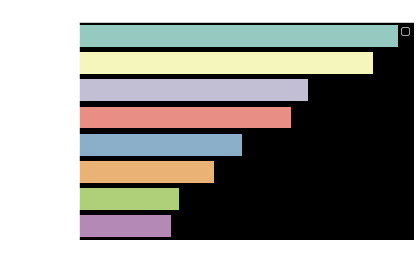

In [90]:
# Create feature importance array based on the model results and which features were inputted into it
feature_imp = pd.Series(clf.feature_importances_,index=X.columns.values).sort_values(ascending=False)

import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

You can see that title, sex and age are the most important features in prediciting the survival of Titanic passengers

Parch (number of parents and kids) is of little importance so let's drop it from the model. This will help to avoid overfitting.

In [55]:
df_train = df_train.drop(['Parch'], axis = 1)
df_test = df_test.drop(['Parch'], axis = 1)

# Hyperparameter Tuning
Let's tune the parameters of the model to see if we can increase the accuracy 

In [126]:
# The parameter ranges were taken from other examples online that used random search training to find an appropiate range for parameters
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}

from sklearn.model_selection import GridSearchCV, cross_val_score

# Create base model to tune
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

# Fit moel
clf.fit(X_train, y_train)

clf.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 16,
 'n_estimators': 100}

Let's define the tuned parameters so we can plug them back into the model

In [136]:
criterion = 'entropy'
min_samples_leaf = 1
min_samples_split = 16
n_estimators = 100

In [137]:
# Initiate model with tuned parameters 
rf = RandomForestClassifier(criterion = criterion, 
                                       min_samples_leaf = min_samples_leaf, 
                                       min_samples_split = min_samples_split,   
                                       n_estimators=n_estimators, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)


# Train the model using the training sets 
clf.fit(X_train,y_train)

# Caculate predicted labels using the random forest model
y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct? This number represents how well the model predicted people would survive compared to the reality
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8171641791044776


With hyperparameter tuning, the models accuracy has increased from 79.9% to 81.7%. I'd take this as a win.

# Further Model Evaluation 

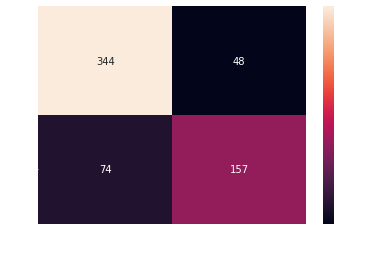

In [125]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Prediction of RF model
predictions = cross_val_predict(rf, X_train, y_train, cv=3)

# Create confusion matrix DF with predictions and expected (y_train)
confusion_matrix = pd.crosstab(y_train, predictions, rownames=['Actual'], colnames=['Predicted'])

# Plot matrix
sns.heatmap(confusion_matrix, annot=True, fmt='g')

The model gave a high number of true falses and true positives. For instance, the model correctly predicted that 344 passengers would not survive but incorrectly predicted that 74 passengers that would not survive.

To get an overall view of the model let's calculate the precision (What proportion of positive identifications was actually correct?) and recall (What proportion of actual positives was identified correctly?)

In [139]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train, predictions))
print("Recall:",recall_score(y_train, predictions))

Precision: 0.7658536585365854
Recall: 0.6796536796536796


Finally, let's combine recall and precision into one score - the F-score.

In [140]:
from sklearn.metrics import f1_score
f1_score(y_train, predictions)

0.7201834862385321

# Submit Predictions

In [167]:
features = ['Pclass', 'Sex', 'Age',	'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']

In [168]:
predictions=clf.predict(df_test[features])

In [174]:
# Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
submission = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':predictions})
submission.head(10)

(418, 2)

In [178]:
#Convert DataFrame to a csv file that can be uploaded
submission.to_csv(r"C:\Users\richard.dudbridge\Documents\Python Scripts\Titanic Predictions 1.csv",index=False)